In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from typing import List, Tuple

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml

import tqdm
tqdm.tqdm.pandas()
#plt.style.use('ggplot')

/nfs/staff-ssd/geisler/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from notebooks import mpl_latex

In [5]:
#mpl_latex.enable_production_mode()

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [7]:
labels_to_plot = [
    'Soft Medoid GDC',
    #'Soft Residual GDC ($T=0.2$)',
    'Vanilla GCN',
    'Vanilla GDC',
    #'SVD GCN',
    #'Jaccard GCN',
    #'RGCN'
]

In [8]:
df_experiments = seml.get_results('kdd21_rgnn_at_scale_attack_evasion_transfer_block_size',
                                  to_data_frame=True,
                                  fields=['batch_id', 'slurm', 'config', 'result'])

df_experiments.head()

/nfs/homedirs/geisler/code/seml/seml/evaluation.py:47: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


,_id,batch_id,slurm.experiments_per_job,slurm.sbatch_options.gres,slurm.sbatch_options.mem,slurm.sbatch_options.cpus-per-task,slurm.sbatch_options.time,slurm.sbatch_options.nodes,slurm.sbatch_options.job-name,slurm.sbatch_options.array,slurm.sbatch_options.output,slurm.array_id,slurm.task_id,config.overwrite,config.db_collection,config.dataset,config.attack,config.attack_params.epochs,config.epsilons,config.surrogate_params.n_filters,config.surrogate_params.dropout,config.surrogate_params.train_params.lr,config.surrogate_params.train_params.weight_decay,config.surrogate_params.train_params.patience,config.surrogate_params.train_params.max_epochs,config.binary_attr,config.seed,config.artifact_dir,config.pert_adj_storage_type,config.pert_attr_storage_type,config.model_storage_type,config.device,config.display_steps,config.model_label,result.results,config.attack_params.search_space_size,config.attack_params.loss_type,config.attack_params.fine_tune_epochs,config.attack_params.keep_heuristic,config.attack_params.stop_optimizing_if_label_flipped
0,6,1,1,gpu:1,16G,4,0-04:00,1,rgnn_at_scale_attack_evasion_transfer_block_si...,0-119,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209376,5,6,kdd21_rgnn_at_scale_attack_evasion_transfer_bl...,cora_ml,PGD,300.0,"[0, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,0,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN
1,7,1,1,gpu:1,16G,4,0-04:00,1,rgnn_at_scale_attack_evasion_transfer_block_si...,0-119,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209376,6,7,kdd21_rgnn_at_scale_attack_evasion_transfer_bl...,cora_ml,PGD,300.0,"[0, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,1,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN
2,8,1,1,gpu:1,16G,4,0-04:00,1,rgnn_at_scale_attack_evasion_transfer_block_si...,0-119,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209376,7,8,kdd21_rgnn_at_scale_attack_evasion_transfer_bl...,cora_ml,PGD,300.0,"[0, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,5,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN
3,9,1,1,gpu:1,16G,4,0-04:00,1,rgnn_at_scale_attack_evasion_transfer_block_si...,0-119,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209376,8,9,kdd21_rgnn_at_scale_attack_evasion_transfer_bl...,cora_ml,PGD,300.0,"[0, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,42,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN
4,10,1,1,gpu:1,16G,4,0-04:00,1,rgnn_at_scale_attack_evasion_transfer_block_si...,0-119,/nfs/homedirs/geisler/code/robust_gnns_at_scal...,6209376,9,10,kdd21_rgnn_at_scale_attack_evasion_transfer_bl...,cora_ml,PGD,300.0,"[0, 0.05, 0.1, 0.25]",64,0.5,0.01,0.001,100,3000,False,100,cache,evasion_transfer_attack_adj,evasion_transfer_attack_attr,pretrained,0,10,None,"[{'label': 'Vanilla GCN', 'epsilon': 0, 'accur...",NaN,NaN,NaN,NaN,NaN


In [9]:
df_experiments.columns

Index(['_id', 'batch_id', 'slurm.experiments_per_job',
       'slurm.sbatch_options.gres', 'slurm.sbatch_options.mem',
       'slurm.sbatch_options.cpus-per-task', 'slurm.sbatch_options.time',
       'slurm.sbatch_options.nodes', 'slurm.sbatch_options.job-name',
       'slurm.sbatch_options.array', 'slurm.sbatch_options.output',
       'slurm.array_id', 'slurm.task_id', 'config.overwrite',
       'config.db_collection', 'config.dataset', 'config.attack',
       'config.attack_params.epochs', 'config.epsilons',
       'config.surrogate_params.n_filters', 'config.surrogate_params.dropout',
       'config.surrogate_params.train_params.lr',
       'config.surrogate_params.train_params.weight_decay',
       'config.surrogate_params.train_params.patience',
       'config.surrogate_params.train_params.max_epochs', 'config.binary_attr',
       'config.seed', 'config.artifact_dir', 'config.pert_adj_storage_type',
       'config.pert_attr_storage_type', 'config.model_storage_type',
       'confi

In [10]:
df_results = [
    pd.DataFrame(r) 
    for r in df_experiments['result.results']
]
for df_result, (_, df_experiment) in zip(df_results, df_experiments.iterrows()):
    df_result['dataset'] = df_experiment['config.dataset']
    df_result['attack'] = df_experiment['config.attack']
    df_result['block_size'] = df_experiment['config.attack_params.search_space_size']
    df_result['seed'] = df_experiment['config.seed']
    df_result['epochs'] = df_experiment['config.attack_params.epochs']
    df_result['novel_loss'] = (
        (df_experiment['config.attack_params.loss_type'] == 'MCE')
        | (df_experiment['config.attack_params.loss_type'] == 'tanhCW')
    )


df_results = pd.concat(df_results, ignore_index=True)
df_results

,label,epsilon,accuracy,dataset,attack,block_size,seed,epochs,novel_loss
0,Vanilla GCN,0.00,0.803162,cora_ml,PGD,NaN,0,300.0,False
1,Vanilla GCN,0.05,0.734783,cora_ml,PGD,NaN,0,300.0,False
2,Vanilla GCN,0.10,0.684980,cora_ml,PGD,NaN,0,300.0,False
3,Vanilla GCN,0.25,0.579842,cora_ml,PGD,NaN,0,300.0,False
4,Vanilla GDC,0.00,0.832806,cora_ml,PGD,NaN,0,300.0,False
...,...,...,...,...,...,...,...,...,...
3995,Soft Medoid GDC (T=0.2),0.25,0.715020,cora_ml,PGD,NaN,100,300.0,True
3996,Soft Medoid GDC (T=0.5),0.00,0.792885,cora_ml,PGD,NaN,100,300.0,True
3997,Soft Medoid GDC (T=0.5),0.05,0.754150,cora_ml,PGD,NaN,100,300.0,True
3998,Soft Medoid GDC (T=0.5),0.10,0.728854,cora_ml,PGD,NaN,100,300.0,True


In [11]:
df_results['label'].unique()

array(['Vanilla GCN', 'Vanilla GDC', 'Soft Medoid GDC (T=1.0)',
       'Soft Medoid GDC (T=0.5)', 'Soft Medoid GDC (T=0.2)', 'SVD GCN',
       'Jaccard GCN', 'RGCN'], dtype=object)

In [12]:
df_results.label = df_results.label.apply(
    lambda m: m.replace(r' (T=0.2)', '')
)
df_results.label.unique()

array(['Vanilla GCN', 'Vanilla GDC', 'Soft Medoid GDC (T=1.0)',
       'Soft Medoid GDC (T=0.5)', 'Soft Medoid GDC', 'SVD GCN',
       'Jaccard GCN', 'RGCN'], dtype=object)

In [13]:
epsilons = [0.1, 0.25]

In [14]:
attack_names = {
    #'GreedyRBCD': 'Greedy',
    'PRBCD': 'PGD'
}

novel_loss
cora_ml
PRBCD
0.1
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
SVD GCN
Jaccard GCN
RGCN


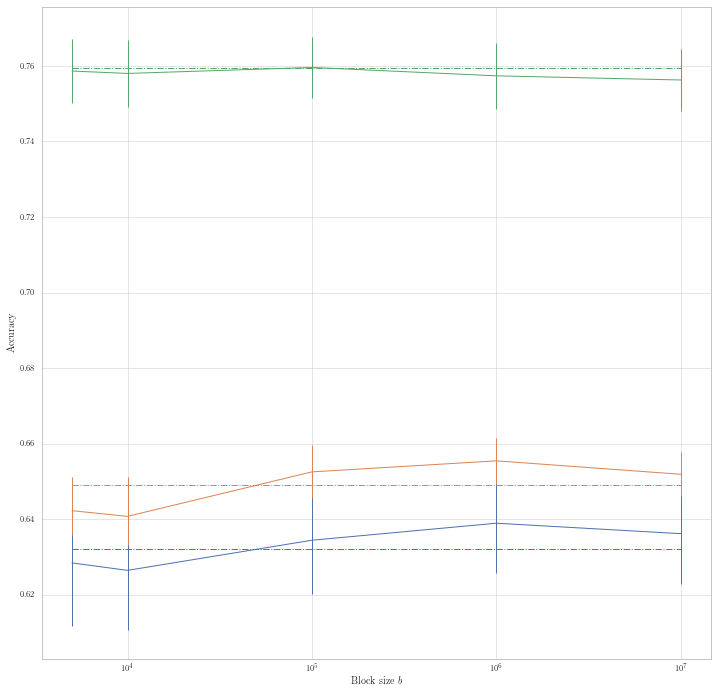

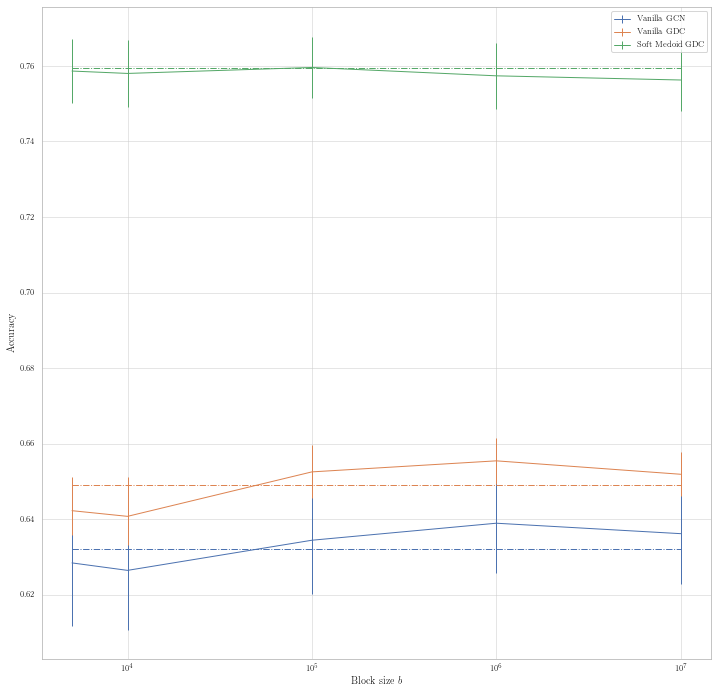

0.25
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
SVD GCN
Jaccard GCN
RGCN


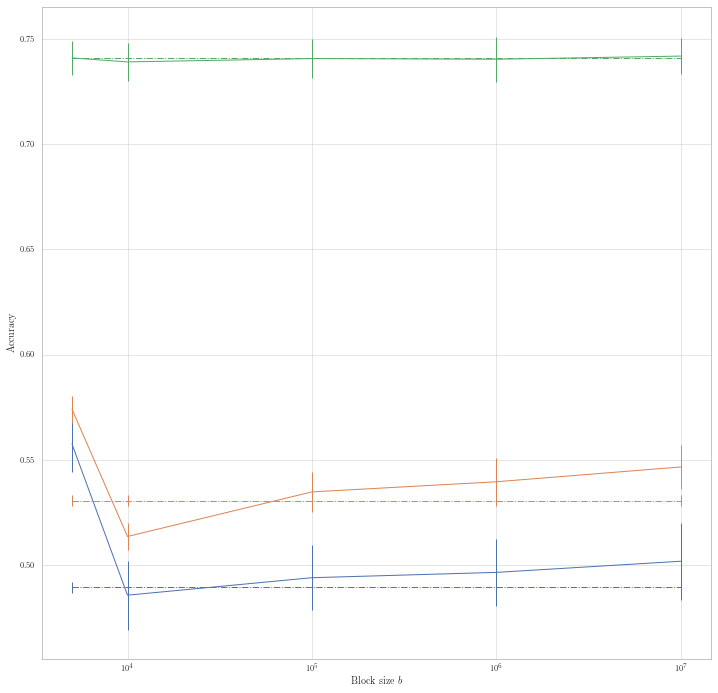

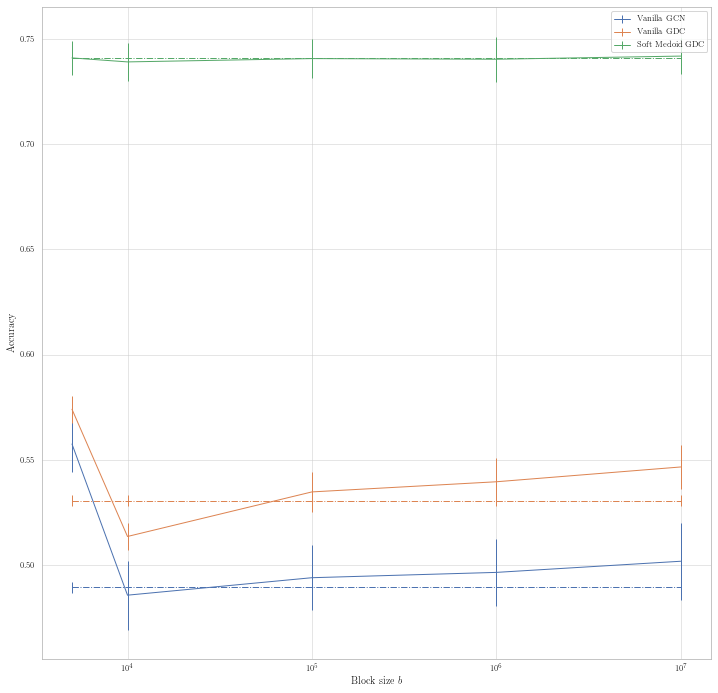

CE
cora_ml
PRBCD
0.1
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
SVD GCN
Jaccard GCN
RGCN


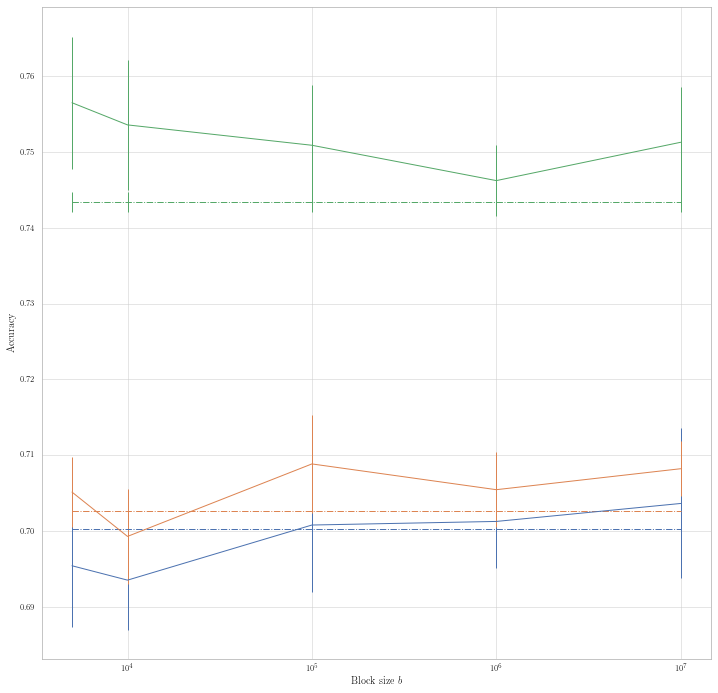

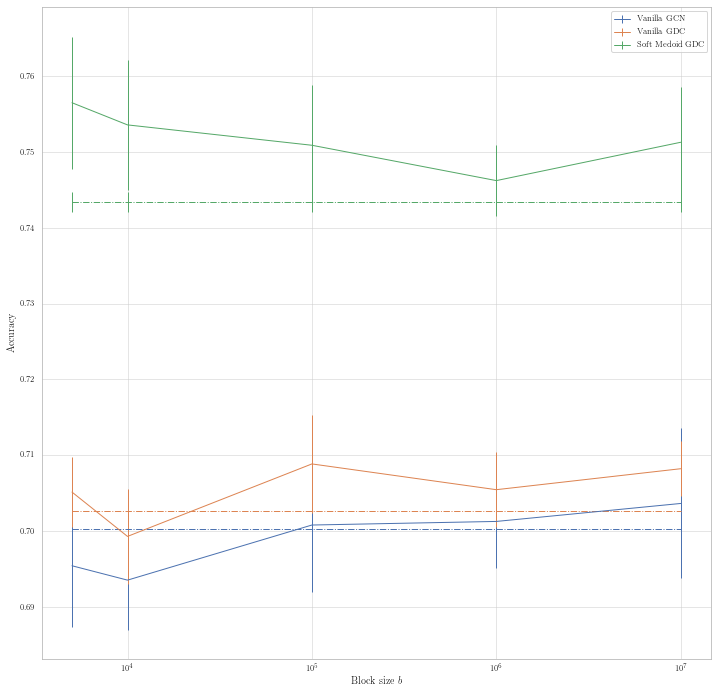

0.25
Soft Medoid GDC (T=1.0)
Soft Medoid GDC (T=0.5)
SVD GCN
Jaccard GCN
RGCN


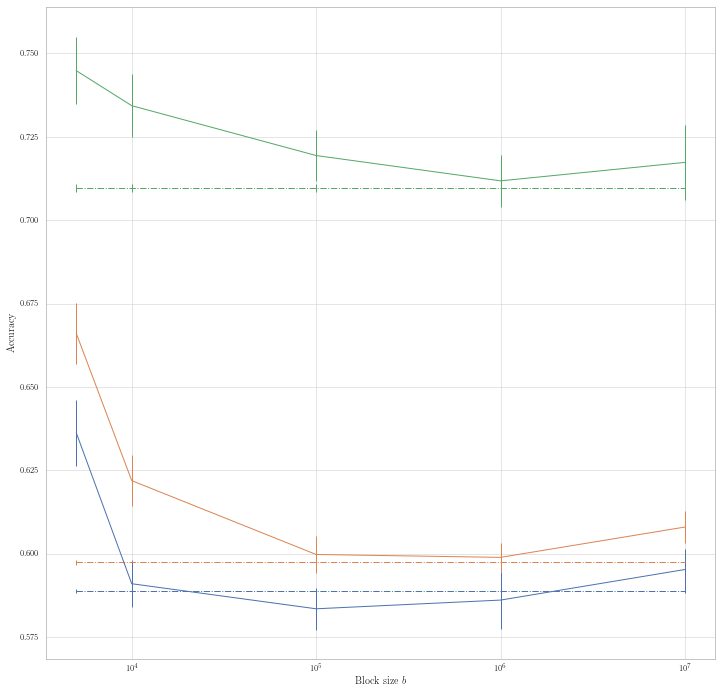

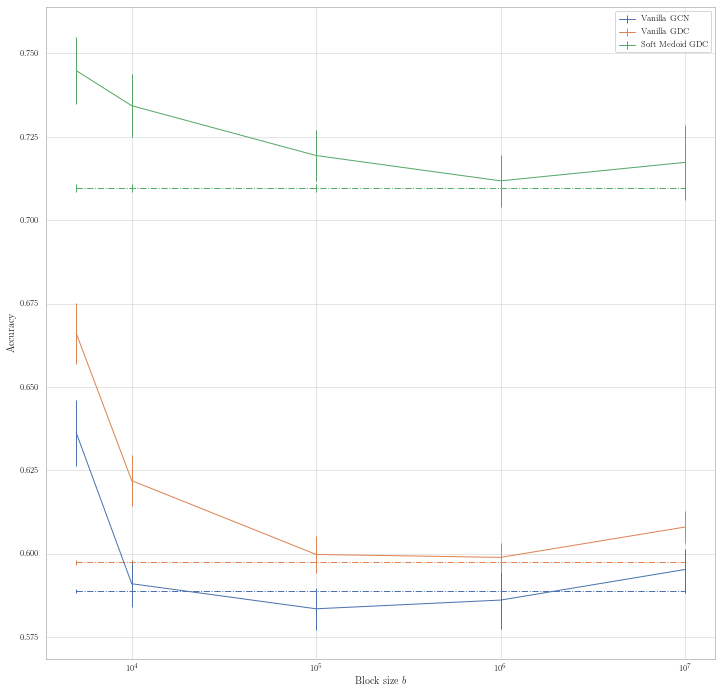

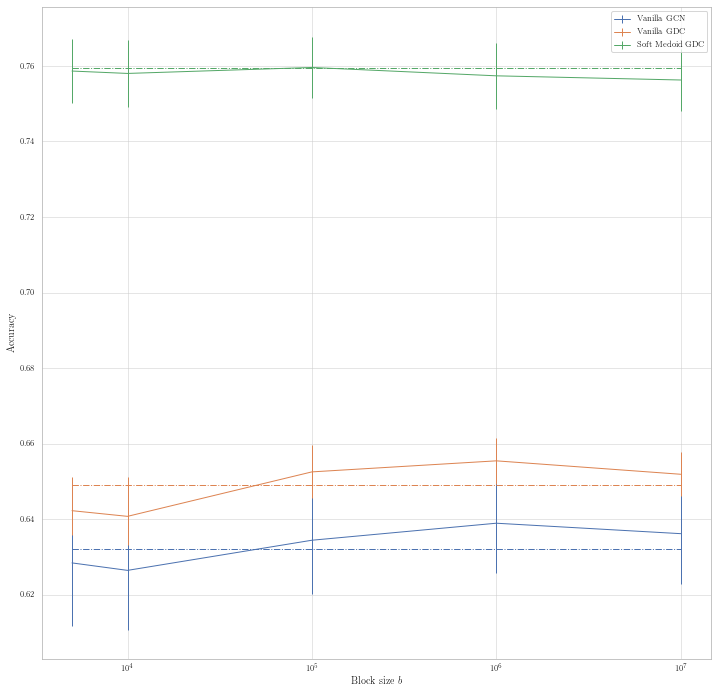

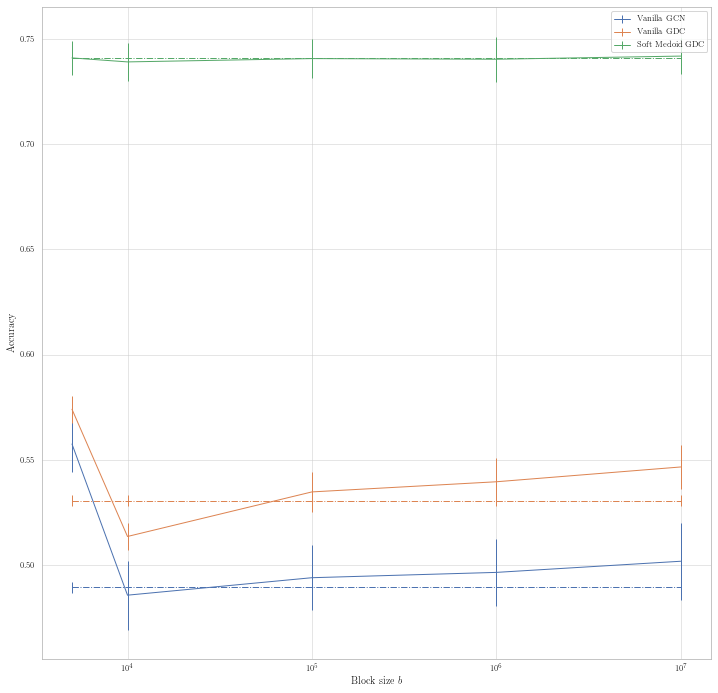

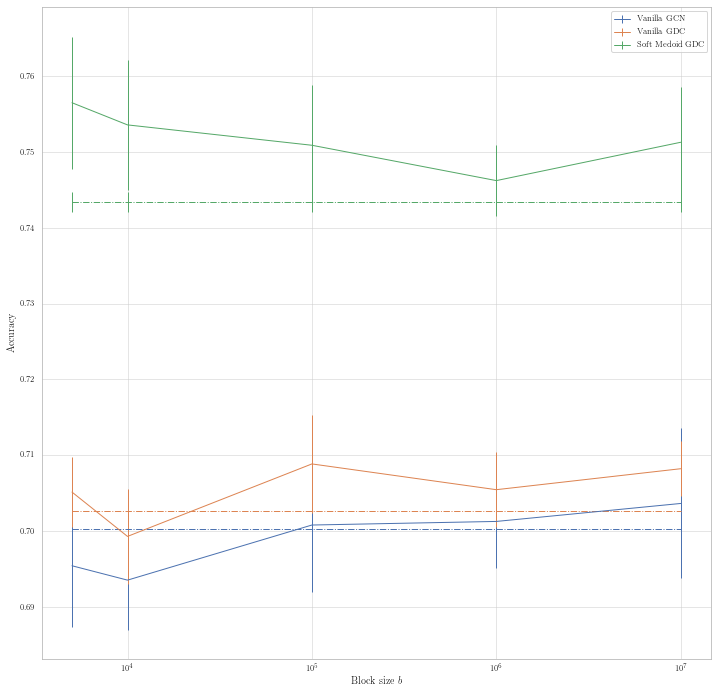

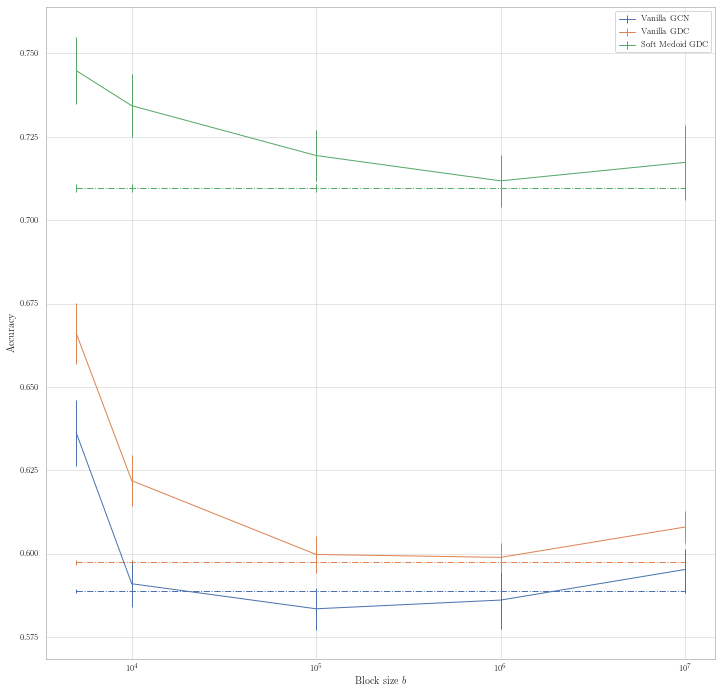

In [16]:
for novel_loss in [True, False]:
    loss = 'novel_loss' if novel_loss else 'CE'
    print(loss)
    for dataset in df_results.dataset.unique():
        print(dataset)
        for attack in attack_names.keys():
            print(attack)
            for epsilon in epsilons:
                print(epsilon)

                fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
                for label in df_results.label.unique():
                    if label not in labels_to_plot:
                        continue
                    group = df_results[(df_results.dataset == dataset)
                               & (df_results.attack == attack_names[attack])
                               & (df_results.label == label)
                               & (df_results.epsilon == epsilon)
                               & (df_results.novel_loss == novel_loss)]

                    if not group.shape[0]:
                        print(f'No experiment with label {label}, dataset {dataset} and attack {attack} found')
                        continue

                    accs = group.accuracy.mean()
                    acc_error = group.accuracy.std() / group.accuracy.size

                    block_sizes = df_results[(df_results.dataset == dataset)
                                     & (df_results.attack == attack)].block_size.unique()
                    plt.errorbar(
                        block_sizes,
                        [accs] * block_sizes.size,
                        [acc_error] * block_sizes.size,
                        linestyle='-.'
                    )
                plt.gca().set_prop_cycle(None)

                for label in df_results.label.unique():
                    if label not in labels_to_plot:
                        print(label)
                        continue
                    group = df_results[(df_results.dataset == dataset)
                               & (df_results.attack == attack)
                               & (df_results.label == label)
                               & (df_results.epsilon == epsilon)
                               & (~df_results.epochs.isna())
                               & (df_results.novel_loss == novel_loss)]

                    if not group.shape[0]:
                        print(f'No experiment with label {label}, dataset {dataset} and attack {attack} found')
                        continue

                    accs = group.groupby('block_size').accuracy.mean()
                    sizes = group.groupby('block_size').accuracy.size()
                    acc_error = 3 * group.groupby('block_size').accuracy.agg(lambda accs: accs.std()) / sizes

                    plt.errorbar(
                        accs.index,
                        accs,
                        acc_error,
                        label=label,
                        linestyle='-'
                    )
                plt.gca().set_prop_cycle(None)

                #plt.title(f'Dataset={dataset}, Attack={attack_names[attack]}'.replace('_', ' '))
                plt.ylabel('Accuracy')
                plt.xlabel('Block size $b$')
                plt.xscale('log')
                plt.xticks([1e4, 1e5, 1e6, 1e7])
                mpl_latex.savefig(f'latex/assets/global_{attack}_{loss}_{dataset}_{epsilon}_block_size_no_legend', fig, close_fig=False)
                plt.legend()
                mpl_latex.savefig(f'latex/assets/global_{attack}_{loss}_{dataset}_{epsilon}_block_size', fig, close_fig=False)
                mpl_latex.dedicated_legend_plot(
                    f'latex/assets/global_{attack}_{loss}_{dataset}_{epsilon}_block_size_legend',
                    mod_label=lambda l: l,
                    ncol=3
                )